In [1]:
### Notebook for P3D stuff!

import jax
jax.config.update('jax_platform_name', 'gpu')
from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

import numpy as np
import jax.numpy as jnp

%pylab inline

gpu
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
!nvidia-smi

Sun Mar 16 21:02:03 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      Off| 00000000:1A:00.0 Off |                  N/A |
| 16%   31C    P2               49W / 250W|    177MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

/home/guoqi/.conda/envs/MAPLE/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


|   2  Tesla V100-PCIE-32GB            Off| 00000000:1F:00.0 Off |                    0 |
| N/A   43C    P0               44W / 250W|    312MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   3  Tesla V100-PCIE-32GB            Off| 00000000:20:00.0 Off |                    0 |
| N/A   42C    P0               39W / 250W|    312MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   4  Tesla V100-PCIE-32GB            Off| 00000000:21:00.0 Off |                    0 |
| N/A   41C    P0               37W / 250W|    312MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------

In [3]:
jax.__version__

'0.4.26'

In [4]:
#First things... set the redshift

z= 2.0

#set box geometry

bs =  320#box size in Mpc/h
nc =  128#number of pixels per side

mesh_shape = [nc,nc,nc]
box_size = [bs,bs,bs]

ptcl_grid_shape = (nc,) * 3
ptcl_spacing = bs/nc

#number of kbins 

#n_kbins = 10
#kbins = np.logspace(-2.2,np.log10(0.6),n_kbins)


In [5]:
print(ptcl_grid_shape,ptcl_spacing)

(128, 128, 128) 2.5


In [6]:
 def rfftnfreq_2d(shape, spacing, dtype=np.float64):
    """Broadcastable "``sparse``" wavevectors for ``numpy.fft.rfftn``.

    Parameters
    ----------
    shape : tuple of int
        Shape of ``rfftn`` input.
    spacing : float or None, optional
        Grid spacing. None is equivalent to a 2π spacing, with a wavevector period of 1.
    dtype : dtype_like

    Returns
    -------
    kvec : list of jax.numpy.ndarray
        Wavevectors.

    """
    freq_period = 1
    if spacing is not None:
        freq_period = 2 * np.pi / spacing

    kvec = []
    for axis, s in enumerate(shape[:-1]):
        k = np.fft.fftfreq(s).astype(dtype) * freq_period
        kvec.append(k)

    k = np.fft.rfftfreq(shape[-1]).astype(dtype) * freq_period
    kvec.append(k)

    kvec = np.meshgrid(*kvec, indexing='ij', sparse=True)

    return kvec

kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
kvec
k = jnp.sqrt(sum(k**2 for k in kvec))
print(k.shape)

/tmp/ipykernel_38726/572136444.py:36: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  k = jnp.sqrt(sum(k**2 for k in kvec))
2025-03-16 21:02:12.071955: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.8.93). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(128, 128, 65)


In [7]:
kz = jnp.ones(k.shape)*kvec[0]**2
kx = jnp.ones(k.shape)*(kvec[1]**2+kvec[2]**2)
kk = (kx+kz)+10**(-8)
kmu = (kz/(k**2+0.00001))


In [8]:
#m_array[:,0][:50].max()
from jax import jit, checkpoint, custom_vjp
from jax.scipy.ndimage import map_coordinates

m_array = np.load("pkmu_red_mu4.npy")
m_array = jnp.array(m_array)

kmax = m_array[-1,0]

#coords = np.array([np.sqrt(ksquared).flatten()/kmax*50-0.1983166*3,kmu.flatten()*4/0.9386239])
#output  = map_coordinates(
 #           m_array[:,2].reshape(4,50).T, coords, mode="nearest",order=1
 #       )
#func2 = output.reshape(512,512,257)

In [9]:
m_array[:,2].shape

(100,)

In [10]:
import jaxinterp2d
k_in = (k.flatten()/kmax*50-0.1983166*3)
mu_in = kmu.flatten()*4*1.0655

func = jax.nn.relu(map_coordinates(m_array[:,2].reshape(4,25).T[:,::-1],np.array([k_in,mu_in]),mode="nearest",order=1))
func = func.reshape(128,128,65)

In [11]:
np.save("func",func)

In [12]:
tff = m_array[:,2].reshape(4,25)
theta_fid = m_array[:,2].reshape(4,25)[:,:9]

def power_b(theta,tff=tff):
    tff = tff.at[:,:9].set(theta.reshape(4,9))
    
    func = map_coordinates(tff.T[:,:],np.array([k_in,mu_in]),mode="nearest",order=1)
    return func.reshape(128,128,65)/15



In [13]:
#muse componenet...
from functools import partial
import jax
import jax.numpy as jnp
from muse_inference.jax import JaxMuseProblem

In [14]:

#file name
prefix = "A_DESI_TEST512_"
loc = "/home/guoqi/P3D/MAPLE-V2/"

naa = np.load(loc+prefix+"naa.npy")
kernel = np.load(loc+prefix+"kernel.npy")
skewers_skn = np.load(loc+prefix+"skewers_skn.npy")
skewers_dla = np.load(loc+prefix+"skewers_dla.npy")
skewers_fin = np.load(loc+prefix+"skewers_fin.npy")



@jit
def cic_readout_jit_jnc(mesh,naa,kernel,bs=False):
    #"highly optimized" CIC, need to preprocess lots of things... don't diff output coords
    meshvals = mesh.flatten()[naa].reshape(-1,8).T#mesh[tuple(neighboor_coords[0,:,:].T.tolist())]
    weightedvals = meshvals.T* kernel[0]
    values = np.sum(weightedvals, axis=-1)
    
    return values



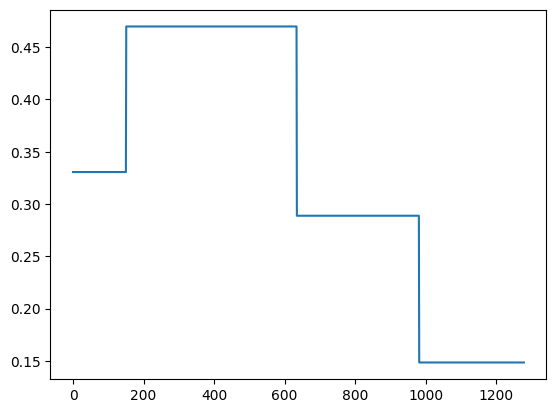

In [15]:
plt.plot(skewers_skn[:128*10])

In [16]:
tf_cut_flat = theta_fid.flatten()

noise_level = 5.0

def gen_map_lya(theta,z):
    modes = z[:nc**3].reshape((nc,nc,nc))    
    Plin = power_b(theta)
    conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
    lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

    lya_values = cic_readout_jit_jnc(lin_modes_real,naa,kernel)
    return lya_values
                 
class Jax3DMuseProblem_flat(JaxMuseProblem):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    #@jax.jit
    def sample_x_z(self, key, θ):
        keys = jax.random.split(key, 2)
        z = jax.random.normal(keys[0], (nc*nc*nc,))
        x = gen_map_lya(θ,z) + (0.05*skewers_skn)*jax.random.normal(keys[1], (kernel.shape[1],)) #1*jax.random.normal(keys[1], (32**3,)).reshape((32,32,32))
   #     print(z.shape,x.shape)
        return (x, z)

  #  @jax.jit
    def logLike(self, x, z, θ):
        return -(jnp.sum((x - gen_map_lya(θ,z))**2/((0.05*skewers_skn)**2))+ jnp.sum(z**2.0))

  #  @jax.jit
    def logPrior(self, θ):
        return -jnp.sum(((θ-jnp.array(tf_cut_flat)*1.1)**2 / (2*(tf_cut_flat*0.4)**2)))
    


In [17]:
sqrt(2)

1.4142135623730951

In [18]:
prob = Jax3DMuseProblem_flat(implicit_diff=True,jit=False)
key = jax.random.PRNGKey(30)
(x, z) = prob.sample_x_z(key, tf_cut_flat)
prob.set_x(x)

In [19]:
x

Array([-0.06407809, -0.0833884 , -0.06665045, ..., -0.10853878,
       -0.03909641,  0.02197754], dtype=float32)

In [20]:
rng = jax.random.PRNGKey(1)

In [21]:
x_data = x

In [22]:
from numpy.random import SeedSequence, default_rng
from copy import copy

start_point = np.abs(jnp.array(tf_cut_flat)*1.2)#+np.random.randn(len(tf_cut_flat))*jnp.array(tf_cut_flat)*0.01)

θ = start_point

maxsteps = 200
nsims=10
rng = jax.random.PRNGKey(1)

def _split_rng(rng, N):
    keyz = []
    for i in range(N):
        rng, subkey = jax.random.split(rng)
        keyz.append(rng)
    return keyz

xz_sims = [prob.sample_x_z(_rng, θ) for _rng in _split_rng(rng, nsims)]
xs = [x_data] + [x for (x,_) in xz_sims]
ẑs = [z*0]     + [z*0 for (x, z) in xz_sims]

In [23]:
import numpy as np
from numbers import Number


def ravel_θ(θ):
    _ravel_θ, _unravel_θ = _ravel_unravel(θ)
    return _ravel_θ(θ)

def unravel_θ(θ):
    _ravel_θ, _unravel_θ = _ravel_unravel(θ)

    return _unravel_θ(θ)

def ravel_z(z):
    _ravel_z, _unravel_z = _ravel_unravel(z)
    return _ravel_z(z)

def unravel_z(z):
    _ravel_z, _unravel_z = _ravel_unravel(z)

    return _unravel_z(z)


def _ravel_unravel(x):
    if isinstance(x, (tuple,list)):
        i = 0
        slices_shapes = []
        for elem in x:
            if isinstance(elem, Number):
                slices_shapes.append((i, None))
                i += 1
            else:
                slices_shapes.append((slice(i,i+elem.size), elem.shape))
                i += elem.size
        ravel = lambda tup: np.concatenate(tup, axis=None)
        unravel = lambda vec: tuple(vec[sl] if shape is None else vec[sl].reshape(shape) for (sl,shape) in slices_shapes)
    elif isinstance(x, Number):
        ravel = lambda val: np.array([val])
        unravel = lambda vec: vec.item()
    elif isinstance(x, dict):
        keys = x.keys()
        ravel_to_tup = lambda dct: tuple(dct[k] for k in keys) if isinstance(dct, dict) else dct
        unravel_tup = lambda tup: {k: v for (k, v) in zip(keys, tup)}
        ravel_tup, unravel_to_tup = _ravel_unravel(ravel_to_tup(x))
        ravel = lambda dct: ravel_tup(ravel_to_tup(dct))
        unravel = lambda vec: unravel_tup(unravel_to_tup(vec))
    else:
        ravel = unravel = lambda z: z
    return (ravel, unravel)

In [24]:
from jax import grad, hessian, jacfwd, jvp, value_and_grad, vmap

def gradθ_hessθ_logPrior(θ, transformed_θ=None):
        g = grad(prob.logPrior)(θ)
        H = hessian(lambda θ_vec: prob.logPrior(unravel_θ(θ_vec)))(ravel_θ(θ))
        return (g, H)

In [25]:
print("hi!")

hi!


step: 1 0.7
step: 2 0.7
step: 3 0.7


/home/guoqi/.conda/envs/MAPLE/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)


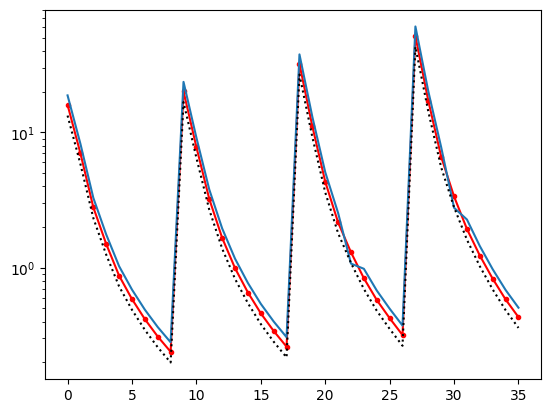

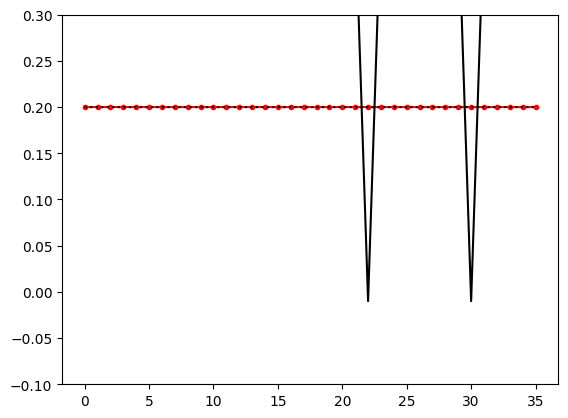

step: 4 0.6649999999999999


/tmp/ipykernel_38726/1494395776.py:51: RuntimeWarning: Mean of empty slice
  s̃_MUSE = unravel_θ(ravel_θ(s̃_MAP_dat) - np.nanmean(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
/home/guoqi/.conda/envs/MAPLE/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1740: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/tmp/ipykernel_38726/1494395776.py:55: RuntimeWarning: Degrees of freedom <= 0 for slice.
  H̃_inv_like_sims = np.diag(-1 / np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))


LinAlgError: SVD did not converge

In [26]:
from datetime import datetime, timedelta
from jax.scipy.optimize import minimize

from multiprocessing.pool import ThreadPool as Pool 
pool = Pool() #jax pmap? check re-compilation times?
pmap = pool.map

#method = 'L-BFGS-B'
method = "l-bfgs-experimental-do-not-rely-on-this"
θ_rtol = 1e-5
z_rtol = 1e-5

θ_tol = 1e-5
z_tol = 1e-6

history = []
α=0.70
beta = 0.25

θ̃unreg = θ̃ = start_point
θunreg = θ = start_point# if result.θ is not None else θ_start)
θL = start_point
Nθ = len(ravel_θ(θ̃))
time = timedelta(0)
for i in range(1, maxsteps+1):
        print("step:",i,α)
        t0 = datetime.now()

        if i > 1:
            xs = [x_data] + [prob.sample_x_z(_rng, θ)[0] for _rng in _split_rng(rng,nsims)]
            θ_tol = np.sqrt(-np.diag(H̃_inv_post)) * θ_rtol

        if i > 2:
            Δθ̃ = ravel_θ(history[-1]["θ̃"])- ravel_θ(history[-2]["θ̃"])
          #  if np.sqrt(-np.inner(Δθ̃, np.inner(np.linalg.pinv(history[-1]["H̃_inv_post"]), Δθ̃))) < θ_rtol:
           #     break

        # MUSE gradient
        def get_MAPs(x_z):
            x, ẑ_prev = x_z
            result = prob.z_MAP_and_score(x, ẑ_prev, θ, method=method, z_tol=z_tol, θ_tol=θ_tol)
            return result

        MAPs = list(pmap(get_MAPs, zip(xs, ẑs)))

        ẑs = [MAP.z for MAP in MAPs]
   #     if save_MAP_history:
    #        MAP_history_dat, *MAP_history_sims = [MAP.history for MAP in MAPs]
        s_MAP_dat, *s_MAP_sims = [MAP.s for MAP in MAPs]
        s̃_MAP_dat, *s̃_MAP_sims = [MAP.s̃ for MAP in MAPs]
        s̃_MUSE = unravel_θ(ravel_θ(s̃_MAP_dat) - np.nanmean(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        s̃_prior, H̃_prior = gradθ_hessθ_logPrior(θ̃, transformed_θ=True)
        s̃_post = unravel_θ(ravel_θ(s̃_MUSE) + ravel_θ(s̃_prior))

        H̃_inv_like_sims = np.diag(-1 / np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
       # try:
        H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        #except:
        #    print("error on Hessian inversion calc, prior ignored and trying again...")
       # H̃_inv_post = H̃_inv_like_sims
        t = datetime.now() - t0
        time += t

        history.append({
            "t":t, "θ̃":θ̃, "θ̃unreg":θ̃unreg, "θ":θ, "θunreg":θunreg,
            "s_MAP_dat": s_MAP_dat, "s_MAP_sims": s_MAP_sims,
            "s̃_MAP_dat": s̃_MAP_dat, "s̃_MAP_sims": s̃_MAP_sims, 
            "s̃_MUSE": s̃_MUSE,
            "s̃_prior": s̃_prior, "s̃_post": s̃_post, 
            "H̃_inv_post": H̃_inv_post, "H̃_prior": H̃_prior, 
            "H̃_inv_like_sims": H̃_inv_like_sims,
            "θ_tol": θ_tol,
        #    "MAP_history_dat": MAP_history_dat, 
         #   "MAP_history_sims": MAP_history_sims,
        })
        θ̃update = np.clip((np.inner(H̃_inv_post, ravel_θ(s̃_post))),-ravel_θ(θ̃)*beta,ravel_θ(θ̃)*beta)
        θ̃unreg = unravel_θ(ravel_θ(θ̃) - α * θ̃update)
        θunreg = θ̃unreg
        θ̃ = θ̃unreg
        θ = θ̃
        #print(θ)
        if i%3==0:
            plt.semilogy(start_point,"r.-")
            plt.plot(θ)
            plt.plot(tf_cut_flat,"k:")
            plt.show()
            
            
            plt.plot((start_point-tf_cut_flat)/tf_cut_flat,"r.-")
            plt.plot((θ-tf_cut_flat)/tf_cut_flat,"k")
            plt.plot((θL-tf_cut_flat)/tf_cut_flat,"k:")
    
            plt.ylim([-.1,.3])
            plt.show()
            
            θL = θ
            α *= 0.95

In [ ]:
print("hi!")

In [ ]:
H̃_inv_like_sims

In [ ]:
plt.plot((θ-tf_cut_flat)/tf_cut_flat)
plt.show()

In [ ]:
s_MAP_sims = history[-1]["s_MAP_sims"]
_, *z_MAP_sims = ẑs

In [ ]:
def z_MAP_guess_from_truth(x, z, θ):
        return unravel_z(0 * ravel_z(z))
    
nsims = 4
    
def get_J(
        result = None,
        θ = None,
        θ_tol = None,
        z_tol = None,
        method = None,
        rng = None,
        nsims = 10, 
        pmap = map,
        progress = False, 
        skip_errors = False,
    ):

        nsims_remaining = nsims 

        if nsims_remaining > 0:
            print(nsims_remaining)
            t0 = datetime.now()

            def get_s_MAP(rng):
                    (x, z) = prob.sample_x_z(rng, θ)
                    z_MAP_guess = prob.z_MAP_guess_from_truth(x, z, θ)
                    return prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).s
                

            rngs = _split_rng(rng, nsims_remaining)
            s_MAP_sims.extend(s for s in pmap(get_s_MAP, rngs) if s is not None)

#            time += datetime.now() - t0

        J = np.atleast_2d(np.cov(np.stack(list(map(ravel_θ, s_MAP_sims))), rowvar=False))
        return J



In [ ]:
J = get_J(rng=rng,θ =θ,method=method, θ_tol=θ_tol, z_tol=z_tol)

In [ ]:
Hs = []

In [ ]:

def pjacobian(f, x, step, pmap=map, pbar=None):
    print(step,x)
    step = step + np.array(0 * x) # make array if scalar

    def column(i):
    
        def v(ε):
            ε_vec = np.array(0 * x)
            ε_vec[i] = ε
            v = f(x + ε_vec)
            if pbar: pbar.update()
            return v

        return (v(step[i]) - v(-step[i])) / (2 * step[i])

    return np.array(list(pmap(column, range(len(x)))))

In [ ]:
z_MAP_sims

In [ ]:
from tqdm import tqdm
from jax.scipy.sparse.linalg import cg

step = None
skip_errors = False
def _get_H_i_old(rng, z_MAP_guess_fid, *, θ, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):
    
    # for each sim, do one fit at fiducial which we'll
    # reuse as a starting point when fudging θ by +/-ϵ
    θfid = θ
    (x, z) = prob.sample_x_z(rng, θfid)
    if z_MAP_guess_fid is None:
        z_MAP_guess = _MAP_guess_from_truth(x, z, θfid)
        z_MAP_guess_fid = z_MAP_and_score(x, z_MAP_guess, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).z

    def get_s_MAP(θvec):
        θ = unravel_θ(θvec)
        (x, _) = prob.sample_x_z(copy(rng), θ)
        return ravel_θ(prob.z_MAP_and_score(x, z_MAP_guess_fid, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).s)

    return pjacobian(get_s_MAP, ravel_θ(θfid), step)


def _get_H_i(rng, z_MAP, *, θ, implicit_diff_cgtol=1e-3, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):

        #implicit implementation..
        cg_kwargs = dict(tol=implicit_diff_cgtol)

        (x, z) = prob.sample_x_z(rng, θ)
        if z_MAP is None:
            z_MAP_guess = z_MAP_guess_from_truth(x, z, θ)
            z_MAP = prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).z

        θ_vec, z_MAP_vec = ravel_θ(θ), ravel_z(z_MAP)
        #unravel_θ, unravel_z = unravel_θ, unravel_z

        # non-implicit-diff term
        H1 = jacfwd(
            lambda θ1: grad(
                lambda θ2: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], z_MAP, unravel_θ(θ2))
            )(θ_vec)
        )(θ_vec)

        # term involving dzMAP/dθ via implicit-diff (w/ conjugate-gradient linear solve)
        dFdθ = jacfwd(
            lambda θ: grad(
                lambda z: prob.logLike(x, unravel_z(z), unravel_θ(θ))
            )(z_MAP_vec)
        )(θ_vec)
        dFdθ1 = jacfwd(
            lambda θ1: grad(
                lambda z: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], unravel_z(z), θ)
            )(z_MAP_vec)
        )(θ_vec)
        inv_dFdz_dFdθ1 = vmap(
            lambda vec: cg(
                lambda vec: jvp(lambda z: grad(lambda z: prob.logLike(x, unravel_z(z), θ))(z), (z_MAP_vec,), (vec,))[1], 
                vec, 
                **cg_kwargs
            )[0], 
            in_axes=1, out_axes=1
        )(dFdθ1)
        H2 = -dFdθ.T @ inv_dFdz_dFdθ1
        return H1 + H2

Hs = []

nsims_remaining = nsims  #- len(result.Hs)

z_MAP_sims = z_MAP_sims[:4]

if nsims_remaining > 0:

    # default to finite difference step size of 0.1σ with σ roughly
    # estimated from s_MAP_sims sims, if we have them
    if step is None:
        if len(s_MAP_sims) > 0:
            step = 0.1 / np.std(np.stack(list(map(ravel_θ, s_MAP_sims))), axis=0)
        else:
            step = 1e-5
    
    Nθ = len(ravel_θ(θ))
    pbar = partial(tqdm, total=nsims_remaining, desc="get_H", disable=(True))

    t0 = datetime.now()
    rngs = _split_rng(rng, nsims)[-nsims_remaining:]
    z_MAP_sims = (z_MAP_sims + [None]*(max(0, nsims - len(z_MAP_sims))))[-nsims_remaining:]
    _get_H_ii = partial(_get_H_i, θ=θ, method=method, θ_tol=θ_tol, z_tol=z_tol, step=step, skip_errors=skip_errors)
    Hs.extend(H for H in pbar(map(lambda args: _get_H_ii(*args), zip(rngs, z_MAP_sims)) )if H is not None)
   # result.time += datetime.now() - t0

avg = np.mean#np.median if use_median else np.mean
H = avg(np.array(Hs), axis=0)

In [ ]:
Hs[0]

In [ ]:
import scipy as sp

Nθ = len(ravel(θ))

H_prior = -ravel(prob.gradθ_hessθ_logPrior(θ, transformed_θ=False)[1]).reshape(Nθ,Nθ)
Σ_inv = H.T @ np.linalg.pinv(J) @ H + H_prior
Σ = np.linalg.pinv(Σ_inv)
try:
    if θ is not None:
        if Nθ == 1:
            dist = sp.stats.norm(ravel(θ), np.sqrt(Σ[0,0]))
        else:
            dist = sp.stats.multivariate_normal(ravel(θ), Σ)
except:
    print("likely error in covariance... proceed with caution!")

In [ ]:
plt.plot(1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.sqrt(np.diag(Σ))/tf_cut_flat)

plt.plot(abs((start_point-θ)/tf_cut_flat),"k:")

In [ ]:
plt.errorbar(np.arange(len(tf_cut_flat)),(θ-tf_cut_flat)/tf_cut_flat,yerr=1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.arange(len(tf_cut_flat)),np.arange(len(tf_cut_flat))*0.0,"k:")
plt.ylim(-0.4,0.4)
plt.show()

In [ ]:
imshow(Σ_inv)
colorbar()

In [41]:
#tf_cut_flat = m_array[:,2].flatten()
start_point = np.abs(jnp.array(tf_cut_flat)+np.random.randn(len(tf_cut_flat))*jnp.array(tf_cut_flat)*0.15)


prob.logLike(x,z,tf_cut_flat)

def problem(theta):
    return prob.logLike(x,z,theta)

vag = jax.value_and_grad(problem)

vag(start_point)

(Array(-20249372., dtype=float32),
 Array([   28394.975,   -39093.875,  1034726.2  ,   939339.9  ,
         3174355.5  ,  2896600.5  ,  -395299.2  , -2251852.2  ,
         -648985.25 ,    71448.8  ,    18843.148,   366854.38 ,
          -51824.78 ,  -486713.7  ,   234351.94 ,   522018.62 ,
           51527.055,   -18938.36 ,    25859.934,   172394.77 ,
           75221.26 ,  -631158.44 ,  -806945.75 ,  -797984.5  ,
         -342492.25 ,    17662.227,  1441140.8  ,   -17715.59 ,
          105064.06 ,   597888.7  ,   334744.62 , -1254400.   ,
          266043.75 ,  2749583.8  ,  1520294.8  ,   835973.9  ],      dtype=float32))

In [ ]:

from multiprocessing.pool import ThreadPool as Pool 
pool = Pool() #jax pmap? check re-compilation times?
pmap = pool.map
result = prob.solve(pmap = pool.map, θ_start=start_point, 
                   rng = jax.random.PRNGKey(1), progress=True,θ_rtol = 1e-5, 
                   maxsteps = 500, nsims=10,α=0.0003,get_covariance=False)


In [ ]:
result.θ

In [ ]:

result = prob.solve(pmap = pool.map, θ_start=start_point,#result.θ, 
                   rng = jax.random.PRNGKey(1), progress=True,θ_rtol = 1e-5, 
                   maxsteps = 1, nsims=100, α=0.0002, get_covariance=True)


In [ ]:
def corr(mat):
    mat2  = mat.copy()
    sdiag = 1./np.sqrt(np.diag(mat))
    for i in range(mat.shape[0]):
        mat2[i,:]=mat[i,:]*sdiag[i]*sdiag[:]
    return mat2

imshow(corr(result.Σ))
colorbar()

In [ ]:
np.diag(result.Σ)

In [ ]:
#plt.plot(result.θ)
plt.errorbar(np.arange(0,result.θ.shape[0]),(result.θ-tf_cut_flat)/result.θ,
             yerr=np.sqrt(np.diag(np.linalg.inv(result.Σ)))/result.θ)

In [ ]:
plt.rcParams['figure.figsize'] = 12,8

plt.errorbar(np.arange(0,result.θ.shape[0]),result.θ/tf_cut_flat,yerr=np.diag(np.sqrt(result.Σ))/tf_cut_flat)
plt.plot(np.arange(0,result.θ.shape[0]),start_point/tf_cut_flat)
plt.plot(np.arange(0,result.θ.shape[0]),tf_cut_flat/tf_cut_flat)

plt.semilogy()

In [ ]:
np.diag(np.sqrt(result.Σ))/tf_cut_flat

In [ ]:
result.θ.reshape(4,18)[, np.arange(0,18).shape

In [ ]:
colors = ["r","b","y","g"]
for i in range(0,4):
    plt.semilogy(tf_cut_flat.reshape(4,18).T[:,i],colors[i])
    plt.errorbar(np.arange(0,18)+i*0.05-0.1,result.θ.reshape(4,18).T[:,i],
                 yerr=np.diag(np.sqrt(result.Σ)).reshape(4,18).T[:,i],
                linestyle=":",
                color=colors[i])


In [ ]:
tf_cut_flat.max()

In [ ]:
plt.semilogy(m_array[:,2].reshape(4,50).T)
#plt.semilogy(m_array[:,2].reshape(4,50)[-1])
plt.semilogy(tf_cut_flat.reshape(4,18).T,"r:")


In [ ]:
plt.loglog(m_array[:,2].reshape(4,50)[-1])

In [ ]:
m_array[:,2].reshape(4,50)[-1]